 # Load the relevant packages

In [1]:
library("SingleCellExperiment")
library("scater")
library("Matrix")
library('scuttle')
library("pheatmap")
library('BPSC')
library('MAST')

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

# Load the data: start with count matrix, then gene and cell annotation data.

In [2]:
gene_annotation <- read.csv("GSE126954_gene_annotation.csv")[,2:3]
cell_annotation <- read.csv("GSE126954_cell_annotation.csv")[,-1]

In [3]:
# Load the saved data matrix from the previous steps. 
load("data_matrix.RData")

# Select one time bin 
out of the timebins
170-210
210-270
270-330
330-390
390-450
450-510
510-580
580-650
"> 650"

In [4]:
timebin="> 650"

In [5]:
cells_bin = cell_annotation[cell_annotation$raw.embryo.time.bin==timebin,]
matrix = data_matrix[,as.numeric(unlist(rownames(cells_bin)))]

In [6]:
write.table("Timebin", "DEG_results.csv", append = T, row.names=F, sep=",", dec=".")
write.table(timebin, "DEG_results.csv", append = T, row.names=F, sep=",", dec=".")

Warning message in write.table("Timebin", "DEG_results.csv", append = T, row.names = F, :
“appending column names to file”
Warning message in write.table(timebin, "DEG_results.csv", append = T, row.names = F, :
“appending column names to file”


# Create SingleCellExperiment object

In [7]:
sce <- SingleCellExperiment(
  assays = list(counts = matrix),
  rowData = data.frame(gene_names = rownames(matrix)),
  colData = data.frame(cell_names = colnames(matrix))
)

# Cleaning & QC
QC should be performed on all the data in this timebin

Use this object to clean the dataset by removing genes that are not expressed in any cell

In [8]:
## Remove genes that are not expressed in any cell
keep_feature <- rowSums(counts(sce) > 0) > 0
sce_filtered <- SingleCellExperiment(
  assays = list(counts = counts(sce)[keep_feature, ]),
  rowData = data.frame(gene_names = rowData(sce)[keep_feature,]),
  colData = data.frame(cell_names = colData(sce))
)

Do some quality control

In [9]:
sce_filtered <- addPerCellQC(sce_filtered)
sce_filtered <- addPerFeatureQC(sce_filtered)
#hist(sce_filtered$total, breaks = 100) #hist of counts per cell

In [10]:
unique_genes_per_cell <- colSums(counts(sce)>0)
#hist(unique_genes_per_cell,breaks=100) #hist of unique genes per cell

If needed, these histograms can be used to determine thresholds for further filtering. 

# Normalize the counts using CPM and get the log norm counts

In [11]:
cpm(sce_filtered) <- calculateCPM(sce_filtered) # using scater package
sce_filtered <- logNormCounts(sce_filtered,transform="log") 
sce_cpm <- cpm(sce_filtered) # CPM for BPSC input
sce_log <- sce_filtered@assays@data@listData$logcounts

# Cell Type Info

In [12]:
cell_type <- cell_annotation[cell_annotation$cell %in% dimnames(sce_log)[[2]],6] 

Unique values in the vector cell_type that is not NA. We do not want to take the type-unidentified (na) cells into the differential expression analysis.

In [13]:
unique_cell_types <- unique(cell_type)[!is.na(unique(cell_type))]
unique_cell_types
length(unique_cell_types)

[1] "Germline"                     "Intestine"                   
 [3] "Z1_Z4"                        "Ciliated_amphid_neuron"      
 [5] "Body_wall_muscle"             "M_cell"                      
 [7] "Glia"                         "Excretory_cell"              
 [9] "Intestinal_and_rectal_muscle" "Ciliated_non_amphid_neuron"  
[11] "Pharyngeal_gland"             "Hypodermis"                  
[13] "Seam_cell"                    "hmc"                         
[15] "Coelomocyte"                  "Excretory_gland"             
[17] "Arcade_cell"                  "Rectal_gland"

[1] 18

In [14]:
cell_type_groups <- c('Muscle','Neuron','Gland','Hypodermis')
cell_indices <- list()
cell_indices[['Muscle']] <- dimnames(sce_log[,which(cell_type %in% c('Body_wall_muscle','Intestinal_and_rectal_muscle','Pharyngeal_muscle'))])[[2]]
cell_indices[['Neuron']] <- dimnames(sce_log[,which(cell_type %in% c('Ciliated_amphid_neuron','Ciliated_non_amphid_neuron','Pharyngeal_neuron'))])[[2]]
cell_indices[['Gland']] <- dimnames(sce_log[,which(cell_type %in% c('Pharyngeal_gland','Parent_of_exc_gland_AVK','Rectal_gland','Excretory_gland'))])[[2]]
cell_indices[['Hypodermis']] <- dimnames(sce_log[,which(cell_type == 'Hypodermis')])[[2]]

In [15]:
length(cell_indices[['Muscle']])
length(cell_indices[['Neuron']])
length(cell_indices[['Gland']])
length(cell_indices[['Hypodermis']])

[1] 685

[1] 587

[1] 89

[1] 43

In [16]:
combinations = data.frame()
for (i in 1:3){
    for (j in (i+1):4){
        row = c(i,j)
        combinations = rbind(combinations, row)
    }
}
combinations

X1L,X2L
<int>,<int>
1,2
1,3
1,4
2,3
2,4
3,4


# Log fold change from MAST + p-value from BPSC

Here we only focus on the predefined list of genes of interest

In [17]:
genes_of_interest = as.matrix(read.delim("genes_of_interest.txt", head=FALSE))
genes_index = which(gene_annotation[,2] %in% genes_of_interest)
GOI = gene_annotation[genes_index,2]
length(GOI)

[1] 88

In [18]:
results <- list()

options(mc.cores = 1) # to fix an error. Has to do with problems in parallelization in idea

for (i in 1:6){
  print(i)
  startTime = Sys.time()
  #Define the two groups to be compared
  control.mat=sce_cpm[GOI,cell_indices[[combinations[i,1]]]]
  treated.mat=sce_cpm[GOI,cell_indices[[combinations[i,2]]]]
  #Create a data set by merging the control group and the treated group
  bp.mat=cbind(control.mat,treated.mat)
  rownames(bp.mat)=c(1:nrow(bp.mat))
  colnames(bp.mat)=c(1:ncol(bp.mat))
  group=c(rep(1,ncol(control.mat)),rep(2,ncol(treated.mat)))
  #Run BPglm for differential expression analysis
  res=BPglm(data=bp.mat, controlIds=which(lapply(group, as.numeric)==1), design=model.matrix(~group), coef=2, estIntPar=FALSE, useParallel=FALSE)
  
  # Use MAST to compute logFC based on the raw counts
  control.countData=sce_filtered[GOI,cell_indices[[combinations[i,1]]]]
  treated.countData=sce_filtered[GOI,cell_indices[[combinations[i,2]]]]
  countData <- cbind(control.countData,treated.countData)
  cellType <- as.data.frame(rep(c(1,2), c(ncol(control.countData),ncol(treated.countData))))
  colnames(cellType) <- "CellType"
  colData(countData) <- cbind(colData(countData),cellType)
  colData(countData)$CellType<-factor(colData(countData)$CellType)
  countData<-SceToSingleCellAssay(countData, class = "SingleCellAssay",check_sanity = FALSE)
  zlmCond <- zlm(~CellType, countData)
  logFC<-getLogFC(zlmCond)[,c(1,3)]
    
  # Log fold change + p-value from BPSC
  PVAL<-as.data.frame(res$PVAL)
  result <- cbind(logFC,res$PVAL)
  colnames(result) <- c('gene','logFC','P-value')
  results[[paste(cell_type_groups[combinations[i,1]],cell_type_groups[combinations[i,2]], sep=" vs. ")]]=result
}

[1] 1


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



[1] 2


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



[1] 3


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



[1] 4


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



[1] 5


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



[1] 6


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



In [19]:
results

gene,logFC,P-value
<chr>,<dbl>,<dbl>
plst-1,0.017588424,1.740243e-01
ced-10,0.039297004,2.601134e-02
deb-1,-0.567207610,1.902923e-16
cap-1,0.054068680,1.225311e-04
dnc-4,0.011364276,7.288268e-02
wsp-1,0.044556446,6.962027e-03
epi-1,-0.200353128,1.877133e-04
dnc-1,-0.005373252,4.729612e-01
jac-1,0.090987107,4.181364e-05


# Filter the DEGs of interest for plotting heatmap
## Filtering criteria: 
## keep the top 25 genes of interest with the lowest P-value from BPSC
## with additional constraints: P-value <0.05; log fold change is not NaN

In [20]:
#If the criteria is to keep the genes with fold change above 2 or below 0.5 anf p-value < 0.05 as DEG, then you can run the following:

#DEG <- list() 
#for (i in 1:6){
#    write.table(names(results)[[i]], "DEG_results.csv", append = T, row.names=F, sep=",", dec=".")
#    write.table(results[[i]][which((results[[i]]$logFC>log10(2) | results[[i]]$logFC<log10(0.5)))], "DEG_results.csv", append = T, row.names=F, sep=",", dec=".")
#    DEG[[names(results)[[i]]]] <- results[[i]]$gene[which(results[[i]]$logFC>log10(2) | results[[i]]$logFC<log10(0.5))]
#}
#DEG <- unique(unlist(DEG))
#writeLines("\nDEG:")
#DEG
#length(DEG)

In [21]:
require(data.table)
dt <- data.table(results[[1]], key="P-value")[, tail(.SD), by='P-value']
dt <- dt[(is.nan(dt$logFC) == FALSE)&(dt$'P-value'<0.05),]
dt[1:25,]
DEG <- unlist(dt[1:25,2])
DEG

Loading required package: data.table


Attaching package: ‘data.table’


The following object is masked from ‘package:SummarizedExperiment’:

    shift


The following object is masked from ‘package:GenomicRanges’:

    shift


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second




P-value,gene,logFC
<dbl>,<chr>,<dbl>
0.000000e+00,mlc-3,-5.9948624
0.000000e+00,mlc-1,-3.0731032
0.000000e+00,act-1,-3.7947575
6.898599e-318,lev-11,-4.9180673
3.930926e-282,mlc-2,-3.2101772
2.173491e-241,act-3,-3.5453881
4.333725e-234,act-4,-4.7025104
1.074418e-98,pat-2,-0.8799101
4.778891e-54,rps-10,-1.5485037


gene1    gene2    gene3    gene4    gene5    gene6    gene7    gene8 
 "mlc-3"  "mlc-1"  "act-1" "lev-11"  "mlc-2"  "act-3"  "act-4"  "pat-2" 
   gene9   gene10   gene11   gene12   gene13   gene14   gene15   gene16 
"rps-10" "unc-60"  "lmn-1"  "pat-3"  "tln-1"  "pfn-3"  "che-3"  "pat-4" 
  gene17   gene18   gene19   gene20   gene21   gene22   gene23   gene24 
 "deb-1"  "act-2"  "hmr-1"  "fmi-1"  "atn-1" "mec-12"  "dys-1"  "cdh-4" 
  gene25 
 "egl-8"

# Heatmap 
Preparation for the heatmap

In [22]:
matList <- list()
cellTypeList <- list()

for (i in 1:4){
  mat <- sce_log[DEG,(cell_indices[[i]])] #input:logcounts
  matList[[i]] <- mat
  cellTypeList[[i]]<-rep(names(cell_indices)[[i]],ncol(mat))
}

mat.whole <- do.call(cbind,matList)
cellType <- do.call(c,cellTypeList)
cellType <- data.frame(cellType)
dim(mat.whole)[2] == nrow(cellType)
colnames(cellType) <- "Cell type"
mat.whole <- data.frame(as.matrix(mat.whole))
rownames(cellType) <- colnames(mat.whole)

[1] TRUE

Show heatmap for the DEG of interest and the 4 cell types

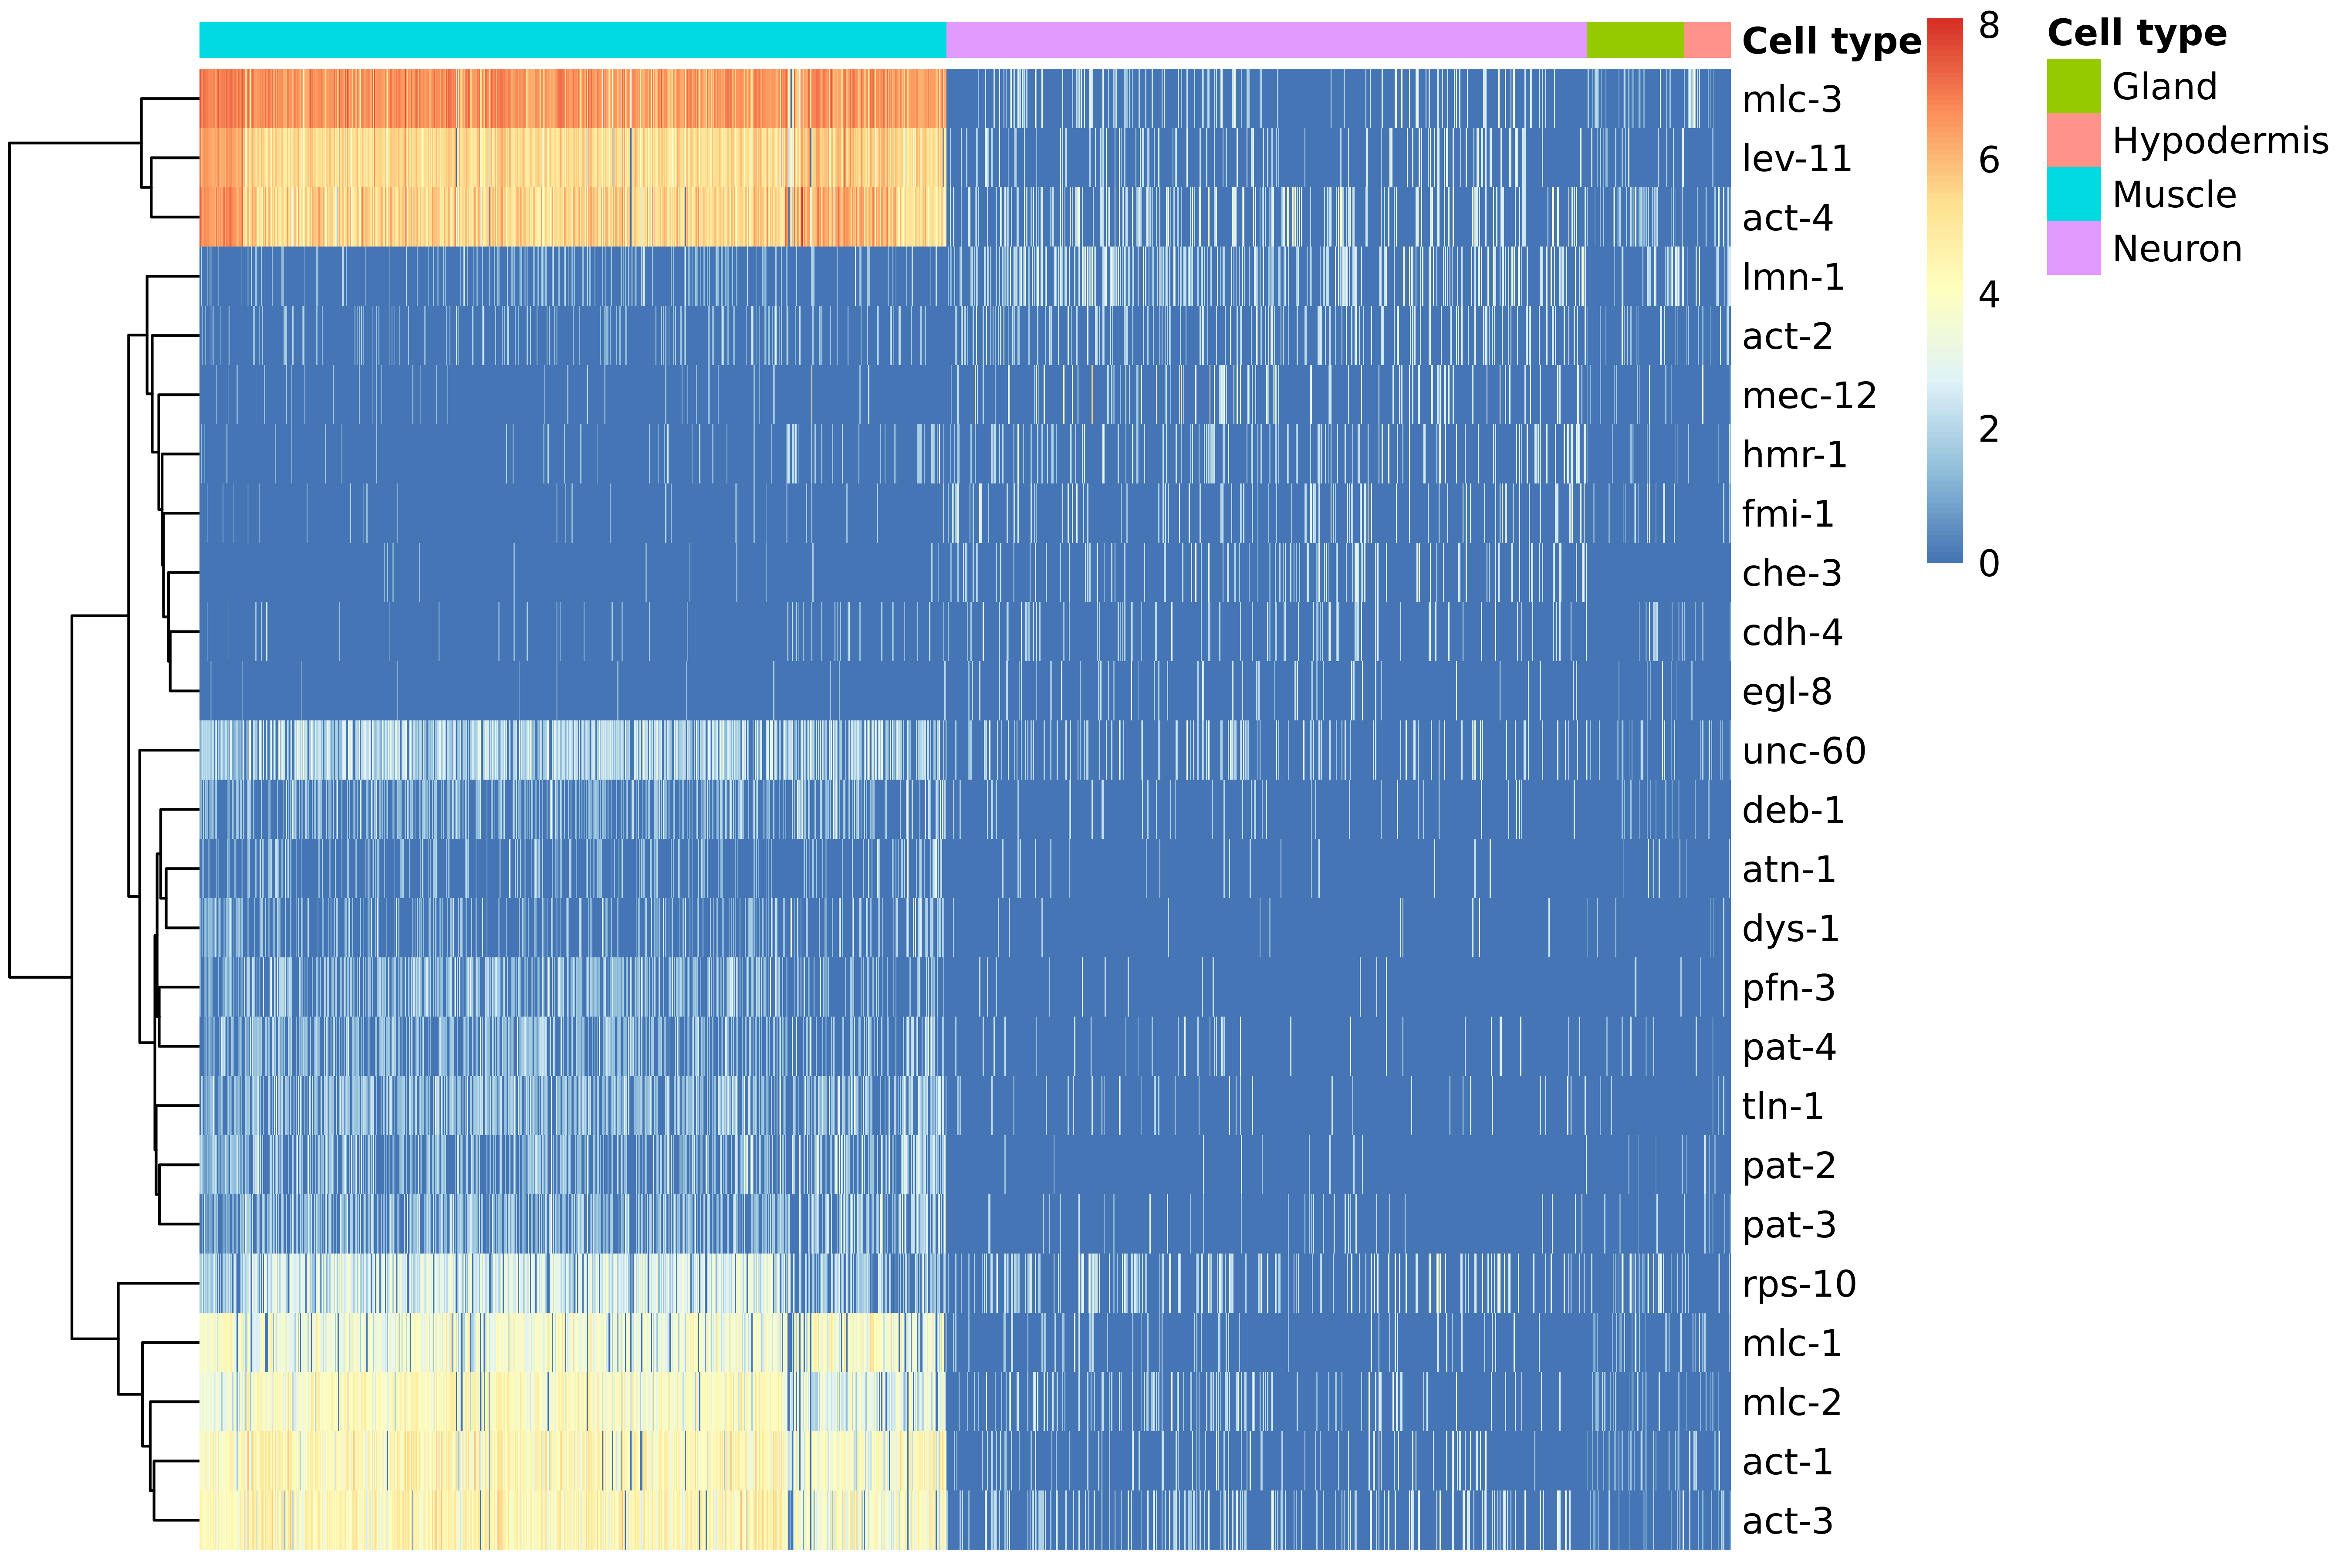

In [23]:
options(repr.plot.width=9, repr.plot.height=6, repr.plot.res = 600)
pheatmap(mat.whole, annotation=cellType, cluster_cols=FALSE, show_colnames=FALSE)
# If you want another color pallette:
#library(RColorBrewer)
#pheatmap(mat.whole, annotation=cellType, cluster_cols=FALSE, show_colnames=FALSE, color = colorRampPalette(brewer.pal(n = 7, name = "YlOrBr"))(100))